# Sakib Hossain (123379133) - Second CA Demo

In [132]:
import os
from google.colab import drive
drive.mount('/content/drive')
base_dir = "./drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

from sklearn.model_selection import train_test_split

from keras import Model
from keras import Input
from keras import regularizers
from keras.layers import Dense
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.layers import GlobalAveragePooling2D

from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.datasets import mnist

from keras.applications import ResNet50
import keras.applications.resnet as resnet

from keras.preprocessing.image import load_img
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import img_to_array

from keras.models import load_model
import cv2

In [134]:
import tensorflow as tf
example_images = image_dataset_from_directory(
    directory=os.path.join(base_dir, "examples"), labels=None, shuffle=False, image_size=(224, 224), batch_size=None)
test_images = tf.convert_to_tensor([example_image for example_image in example_images])

Found 10 files.


In [135]:
best_network = load_model(os.path.join(base_dir, "best_network.keras"))

In [136]:
def show_image(ax, image):
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis("off")

In [137]:
def show_images(images):
    num_images = len(images)
    num_per_row = 5
    num_rows = math.ceil(num_images / num_per_row)
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(num_per_row * 2, num_rows * 2))
    for i, image in enumerate(images):
        r = i // num_per_row
        c = i % num_per_row
        ax = axes[c] if num_rows == 1 else axes[r, c]
        show_image(ax, image)
        ax.axis("off")
    fig.tight_layout()
    plt.show()

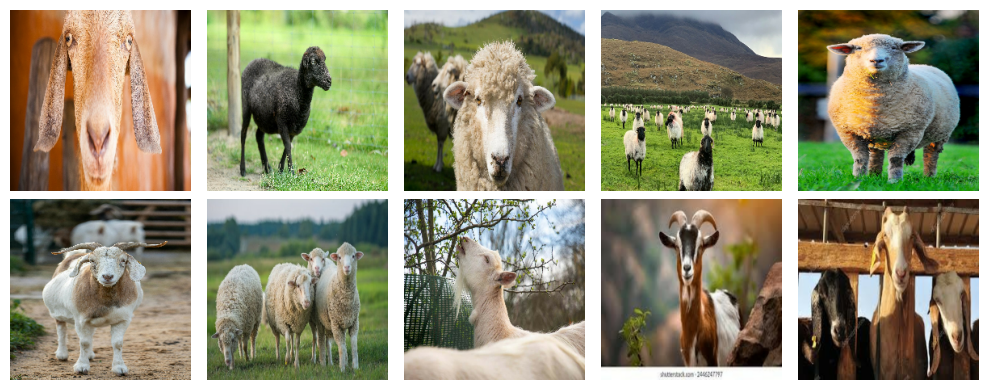

In [138]:
show_images(test_images)

I tried to use a mixture of test images and new images (I don't recall the exact split because I was changing the pictures I used regularly), but in this final example set I tried to use a diverse variety of images. Some of them are high quality full body shots, others are close-ups of the face only, some group photos to see what it classifies for them, and also a couple of unclear, ambigious images to see what it decides on them.

In [139]:
preds = best_network.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [140]:
pred_classes = ["sheep" if p > 0.5 else "goat" for p in preds]

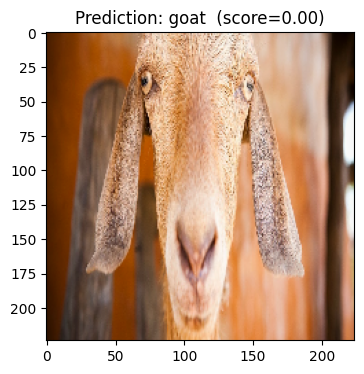

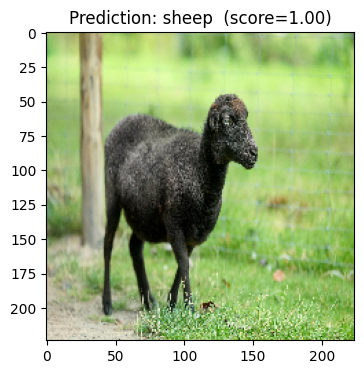

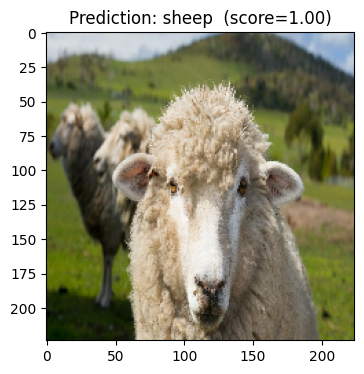

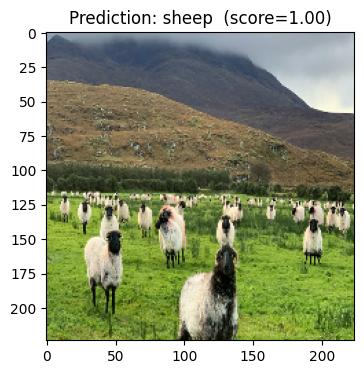

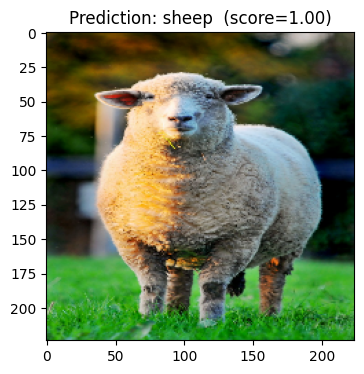

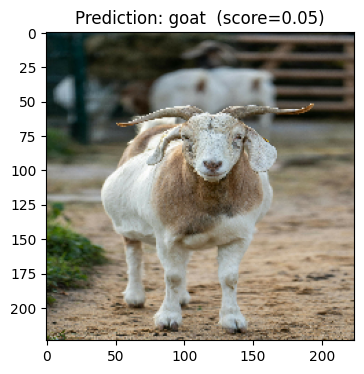

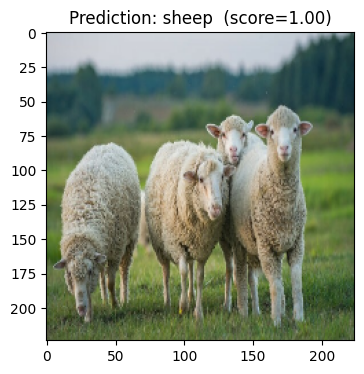

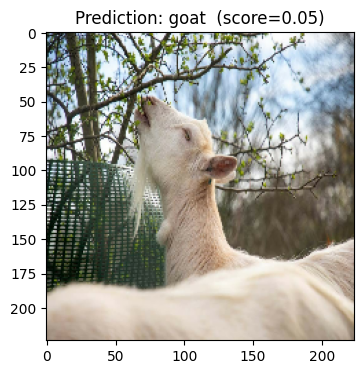

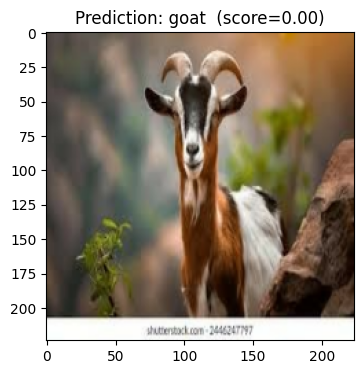

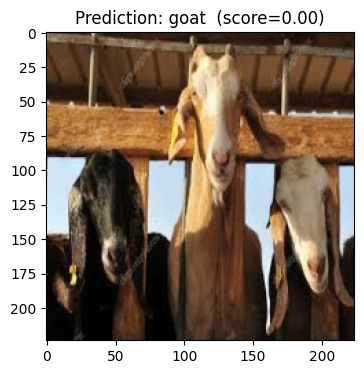

In [141]:
#code to display images with labels and confidence score here taken from ChatGPT
for i, img in enumerate(test_images):
    plt.figure(figsize=(4,4))
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Prediction: {pred_classes[i]}  (score={preds[i][0]:.2f})")
    plt.show()

In [142]:
for i, p in enumerate(preds):
    print(i, p)

0 [0.00491996]
1 [0.99867815]
2 [0.99970216]
3 [0.99961257]
4 [0.99976224]
5 [0.0460652]
6 [0.999201]
7 [0.05375014]
8 [0.00120916]
9 [0.00048171]


The predictions seem too good to be true, as all the images are being classified correctly with extremely high confidence. I've made sure to change images to diversify it and not have just high quality clear images, but it seems to make no difference.

In [143]:
# # ---------------------------
# # GradCAM Class
# # ---------------------------
# class GradCAM:
#     def __init__(self, model, classIdx, layerName=None):
#         self.model = model
#         self.classIdx = classIdx
#         self.layerName = layerName or self.find_target_layer()

#     def find_target_layer(self):
#         # Find the last 4D layer (conv) for Grad-CAM
#         for layer in reversed(self.model.layers):
#             if len(layer.output.shape) == 4:
#                 return layer.name
#         raise ValueError("No 4D layer found.")

#     def compute_heatmap(self, image_list, eps=1e-8):
#         """
#         image_list: list of tensors, one per model input
#         """
#         gradModel = tf.keras.models.Model(
#             inputs=self.model.inputs,
#             outputs=[self.model.get_layer(self.layerName).output, self.model.output]
#         )

#         with tf.GradientTape() as tape:
#             # cast all inputs to float32
#             inputs = [tf.cast(x, tf.float32) for x in image_list]
#             convOutputs, predictions = gradModel(inputs)
#             loss = predictions[:, self.classIdx]

#         grads = tape.gradient(loss, convOutputs)
#         guidedGrads = tf.cast(convOutputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

#         convOutputs = convOutputs[0]
#         guidedGrads = guidedGrads[0]

#         weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
#         cam = tf.reduce_sum(weights * convOutputs, axis=-1)

#         # Get width and height from the first input tensor
#         w, h = image_list[0].shape[2], image_list[0].shape[1]
#         heatmap = cv2.resize(cam.numpy(), (w, h))
#         heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + eps)
#         heatmap = (heatmap * 255).astype("uint8")
#         return heatmap

#     def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
#         heatmap_color = cv2.applyColorMap(heatmap, colormap)
#         overlay = image * alpha + heatmap_color * (1 - alpha)
#         return heatmap_color, overlay.astype(np.uint8)

# # ---------------------------
# # Test Shortcuts Function
# # ---------------------------
# def test_shortcuts(model, image_paths, target_size=(224, 224), occlude=False, occlude_size=50):
#     for img_path in image_paths:
#         # Load and preprocess image
#         img = load_img(img_path, target_size=target_size)
#         img_array = img_to_array(img)
#         img_tensor = np.expand_dims(img_array, axis=0)

#         # Prepare list of tensors matching model.inputs
#         model_input = [img_tensor] * len(model.inputs)  # works for single or multi-input models

#         # Predict class
#         preds = model.predict(model_input)
#         class_idx = np.argmax(preds[0])

#         # Compute Grad-CAM
#         cam = GradCAM(model, class_idx)
#         heatmap = cam.compute_heatmap(model_input)
#         heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
#         _, overlay = cam.overlay_heatmap(heatmap, img_array)

#         # Display original and overlay
#         plt.figure(figsize=(10, 4))
#         plt.subplot(1, 2, 1)
#         plt.imshow(img_array.astype("uint8"))
#         plt.title("Original")
#         plt.axis("off")

#         plt.subplot(1, 2, 2)
#         plt.imshow(overlay)
#         plt.title(f"Grad-CAM Overlay (Class {class_idx})")
#         plt.axis("off")
#         plt.show()

#         # Optional occlusion test
#         if occlude:
#             occluded = img_array.copy()
#             h, w, _ = occluded.shape
#             x_start = np.random.randint(0, w - occlude_size)
#             y_start = np.random.randint(0, h - occlude_size)
#             occluded[y_start:y_start+occlude_size, x_start:x_start+occlude_size, :] = 0

#             occluded_tensor = np.expand_dims(occluded, axis=0)
#             occluded_input = [occluded_tensor] * len(model.inputs)
#             pred_occluded = model.predict(occluded_input)
#             print(f"Prediction drop: {preds[0][class_idx]:.3f} -> {pred_occluded[0][class_idx]:.3f}")

In [144]:
# dataset_dir = "/content/drive/MyDrive/examples/"
# image_paths = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".jpg")]

# test_shortcuts(best_network, image_paths, occlude=True)

The commented out code above is from ChatGPT but I've decided to leave it in here to show that I attempted to learn what shortcuts the model may be learning, however I was unable to get it working despite my best efforts.

Of course, distinguishing the differences between sheeps and goats isn't the hardest of tasks, so it is possible that everything was done correctly, as the training, validation and test accuracies were really high aswell (>~90%).

# Why do I think it gets things right?
There is an abundance of different types of animals on the imagenet site, so it is clear that the model is quite good at distinguishing animals. Of course, I decided to choose two that weren't on the top 1000 list, yet they are still very common animals nonetheless, which is potentially why the model was so adept at classifying them correctly. To test the model even more I added an image of a human to see how it classifies it. The result it gave was a goat, but with a score of 0.22, suggesting it isn't very confident in its classification, which is the desired outcome. Although the model is very confident in most of its classifications, two of the more obsure images of goats had a score of 0.05, and none of the images had 100% confidence, suggesting that it is still generalizing rather than using memorized knowledge (since the images are new). Again, not being able to see what potential shortcuts were learned is not ideal, but I believe my model manipulation and selection methods were logical and clear, so I am happy with the overall outcome of this continous assessment.